In [0]:
import pandas as pd
import numpy as np
import ast
import csv
import time
import random

from operator import itemgetter
import networkx as nx
from networkx.algorithms import community

import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
users=np.zeros((40000,1))

In [4]:
users.shape

(40000, 1)

In [0]:
user_friends={}
user_tags={}
max_friends=0
min_friends=200000
def hasMoreTags(s):
    return s[-1]!=']'

# Generate User: Tags dict

In [6]:
start=time.time()
with open('/content/drive/My Drive/data.csv', 'r') as infile:
    reader = csv.reader(infile)
    count=-1
    
    for row in reader:
        #print(row[:7])
        count += 1
        if count == 0:
            continue
        id=row[0]
        #print(count)
        users[count-1][0]=id
        screenName=row[1]
        
        many_tags=hasMoreTags(row[2])
        
        offset=0
        #print('{} originally'.format(row[2]))
        #print(row[3])
        if many_tags:
            this_tags=[]
            for j in range(20):
                this_tags.append(row[2+j].strip('[]').strip(''))
                if row[2+j][-1]==']':
                    break
            #print('{} many tags'.format(this_tags))
            user_tags[id]=this_tags
            offset=len(this_tags)-1
            #print(offset)
        else:
            user_tags[id]=row[2].strip('[]').strip('')
            
        #followersCount=row[4]
        #print(offset)
        friendsCount=int(row[5+offset])
        #print(row[5+offset])
        max_friends=max(max_friends,friendsCount)
        min_friends=min(min_friends,friendsCount)
        friends=row[9+offset:]
        friends[0]=friends[0].strip('[]')
        friends[-1]=friends[-1].strip('[]')
        friends=[i.replace('"', '') for i in friends]
        friends=[i.strip() for i in friends]
        user_friends[id]=friends
        #print("{} : {}".format(count, friends))
end=time.time()
print('{} seconds'.format(end-start))

18.940265893936157 seconds


In [7]:
print(max_friends)
print(min_friends)

238749
101


# Generate/Read all tags

In [0]:
import re
def remove_hashtag(raw_str):
  return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",raw_str).split())

In [0]:
try:
  all_tags=pd.read_csv('/content/drive/My Drive/all_tags_saved.csv')
except:
  all_tags=set()

  for u in user_tags:
    tags=user_tags[u]

    if type(tags) == str:
      all_tags.add(remove_hashtag(tags))
    else:
      for tag in tags:
        all_tags.add(remove_hashtag(tag))

  pd.DataFrame(list(all_tags)).to_csv('/content/drive/My Drive/all_tags_saved.csv')

In [10]:
len(all_tags)

128

# Generate Tag: User dict

In [0]:
tag_users={}

In [0]:
for u in user_tags:
  tags=user_tags[u]
  if type(tags)==str:
    normalized_tag=remove_hashtag(tags)
    if normalized_tag in tag_users:
      cur_tags=tag_users[normalized_tag]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
    else:
      cur_tags=[]
      cur_tags.append(u)
      tag_users[normalized_tag]=cur_tags
  else:
    for tag in tags:
      normalized_tag=remove_hashtag(tag)
      if normalized_tag in tag_users:
        cur_tags=tag_users[normalized_tag]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags
      else:
        cur_tags=[]
        cur_tags.append(u)
        tag_users[normalized_tag]=cur_tags

In [13]:
len(tag_users)

128

In [0]:
x=list(tag_users.keys())
y=[len(item) for item in tag_users.values()]

tag_nums=pd.DataFrame({'tags':x,'num':y})

# Sort by the num of each tag
sorted_tag_nums=tag_nums.sort_values(by=['num'], ascending=[0])

In [15]:
sorted_tag_nums[:10]

,tags,num
0,nationaldogday,30513
17,respecttylerjoseph,6054
2,gloryoutnow,600
8,backtohogwarts,310
1,narcos,269
76,steve rogers,211
31,louisweloveyou,142
24,bournemouth,130
69,bundesliga,122
27,harry potter,103


In [0]:
sorted_x=sorted_tag_nums['tags'][:5]
sorted_y=sorted_tag_nums['num'][:5]

In [17]:
list(sorted_x)

['nationaldogday',
 'respecttylerjoseph',
 'gloryoutnow',
 'backtohogwarts',
 'narcos']

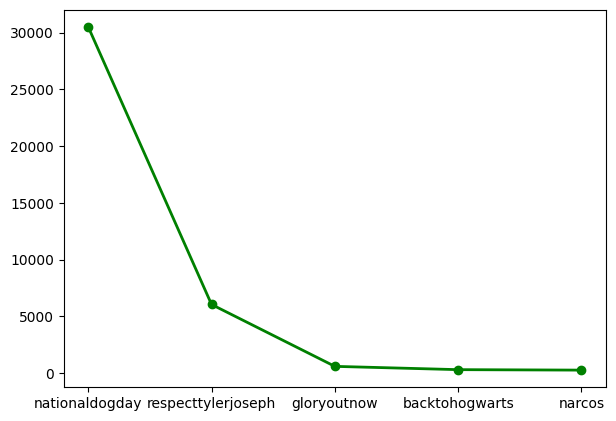

In [18]:
fig, axes = plt.subplots(figsize=(7,5), dpi=100)

plt.plot(sorted_x, sorted_y,'go-', label='line 1', linewidth=2)

In [19]:
# Generate the nodes and edges
nodes=user_friends.keys()
len(nodes)

40000

In [0]:
node_list=list(nodes)
with open('/content/drive/My Drive/nodelist.txt', 'w') as filehandle:
    for listitem in node_list:
        filehandle.write('%s\n' % listitem)

In [0]:
def calculate_shortest_dist(this_tag):
  count=1
  for a in k_nodes:

    no_paths=[]
    shortest_path_list=[]
    shortest_dist=[]

    for b in k_nodes:
      if a==b:
        continue

      try:
        s_path=nx.shortest_path_length(G,a,b)
        shortest_path_list.append((a,b,s_path))
        shortest_dist.append(s_path)

      except:
        no_paths.append((a,b))

    with open('/content/drive/My Drive/%s_shortest_path.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

    with open('/content/drive/My Drive/%s_no_path.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s %s'%x for x in no_paths))

    with open('/content/drive/My Drive/%s_shortest_dist.txt'%this_tag,'a+') as fp:
        fp.write('\n'.join('%s'%x for x in shortest_dist))

    #print('Finished {} node'.format(count))
    count+=1

# Calculate Six Degree under the same tag

In [0]:
top_tags=list(sorted_x)

# Sample 200 user from top 5 tags to calculate 6 degree
k=200

for this_tag in top_tags:
  this_tag_users=set(tag_users[this_tag])
  this_tag_users_list=list(this_tag_users)
  k_nodes=[]

  for i in range(k):
    n1=random.choice(this_tag_users_list)
    k_nodes.append(n1)

  calculate_shortest_dist(this_tag)

# Analyze top 5 tags

In [23]:
for this_tag in top_tags:

   shortest_dist_list = pd.read_csv('/content/drive/My Drive/%s_shortest_dist.txt'%this_tag, names=['dist'], sep=" ", header=None)

   print(this_tag)
   shortest_dist_list['dist'].value_counts().to_csv('/content/drive/My Drive/%s_info.txt'%this_tag,sep=':')
   shortest_dist_list.describe().to_csv('/content/drive/My Drive/%s_info.txt'%this_tag, mode='a',sep=':')

nationaldogday
respecttylerjoseph


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  


gloryoutnow
backtohogwarts
narcos


# Read the graph

In [24]:
begin=time.time()
try:
  # nx.write_gpickle(G,"test.gpickle")
  # Read from pickle
  G=nx.read_gpickle("/content/drive/My Drive/test.gpickle")
  end=time.time()
  print('Spent {} in reading graph'.format(end-begin))
except:
  G=nx.Graph()
  G.add_edges_from(edges)
  end=time.time()
  print('{} seconds'.format(end-start))

Spent 105.43363904953003 in reading graph


In [25]:
########### Print the summary of the graph ###########
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 12891798
Number of edges: 32842959
Average degree:   5.0952


# Calculate the shortest path

In [0]:
#################### Select k nodes #####################
# node_list=[line.rstrip('\n') for line in open('/content/drive/My Drive/nodelist.txt')]

# k=1000
# k_nodes=[]

# for i in range(k):

#   n1=random.choice(node_list)
#   k_nodes.append(n1)

# print('Finished sampling {} nodes'.format(k))

# pairs_count=0
# count=1

# for a in k_nodes:

#   no_paths=[]
#   shortest_path_list=[]
#   shortest_dist=[]

#   for b in k_nodes:
#     if a==b:
#       continue

#     pairs_count+=1

#     try:
#       s_path=nx.shortest_path_length(G,a,b)
#       shortest_path_list.append((a,b,s_path))
#       shortest_dist.append(s_path)

#     except:
#       no_paths.append((a,b))

#   with open('/content/drive/My Drive/%s_shortest_path.txt'%k,'a+') as fp:
#       fp.write('\n'.join('%s %s %s'%x for x in shortest_path_list))

#   with open('/content/drive/My Drive/%s_no_path.txt'%k,'a+') as fp:
#       fp.write('\n'.join('%s %s'%x for x in no_paths))

#   with open('/content/drive/My Drive/%s_shortest_dist.txt'%k,'a+') as fp:
#       fp.write('\n'.join('%s'%x for x in shortest_dist))

#   #print('finished {} node'.format(count))
#   count+=1

#  Analyze the data

In [0]:
shortest_dist_list = pd.read_csv('/content/drive/My Drive/network/5000 users result/5000_shortest_dist.txt', names=['dist'], sep=" ", header=None)

In [28]:
shortest_dist_list['dist'].value_counts()

2     12299845
3      9164037
4      3426535
5        78988
6        10300
1         4379
32        1672
33        1454
42         597
34         468
43         427
7          262
44         121
22         115
23          94
24          26
35           5
53           5
45           4
52           4
63           3
54           2
31           1
64           1
Name: dist, dtype: int64

In [0]:
sd_count=shortest_dist_list['dist'].value_counts().rename_axis('shortest_dist').reset_index(name='counts')

<BarContainer object of 24 artists>

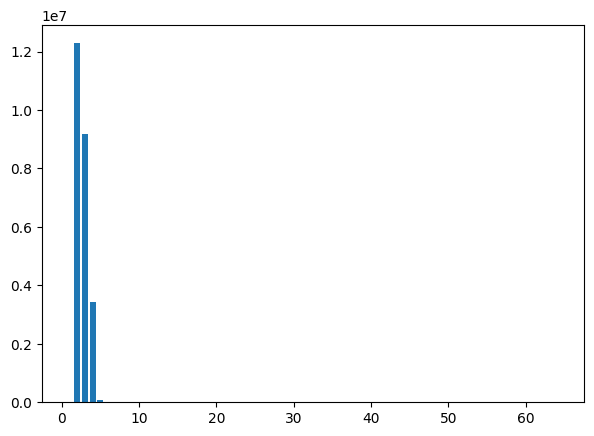

In [30]:
x=sd_count['shortest_dist']
y=sd_count['counts']
fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(x, height=y)

In [31]:
degree_greater_than_6=sd_count.loc[sd_count['shortest_dist'] > 6]
print(degree_greater_than_6)

    shortest_dist  counts
6              32    1672
7              33    1454
8              42     597
9              34     468
10             43     427
11              7     262
12             44     121
13             22     115
14             23      94
15             24      26
16             35       5
17             53       5
18             45       4
19             52       4
20             63       3
21             54       2
22             31       1
23             64       1


In [32]:
degree_greater_than_6_count=degree_greater_than_6['counts'].sum()
print(degree_greater_than_6_count)

5261


In [33]:
degree_less_than_6=sd_count.loc[sd_count['shortest_dist']<6]
print(degree_less_than_6)

   shortest_dist    counts
0              2  12299845
1              3   9164037
2              4   3426535
3              5     78988
5              1      4379


In [34]:
degree_less_than_6_count=degree_less_than_6['counts'].sum()
print(degree_less_than_6_count)

24973784


In [35]:
degree_equal_to_6=sd_count.loc[sd_count['shortest_dist']==6]
print(degree_equal_to_6)
degree_equal_to_6_count=degree_equal_to_6['counts'].sum()
print(degree_equal_to_6_count)

   shortest_dist  counts
4              6   10300
10300


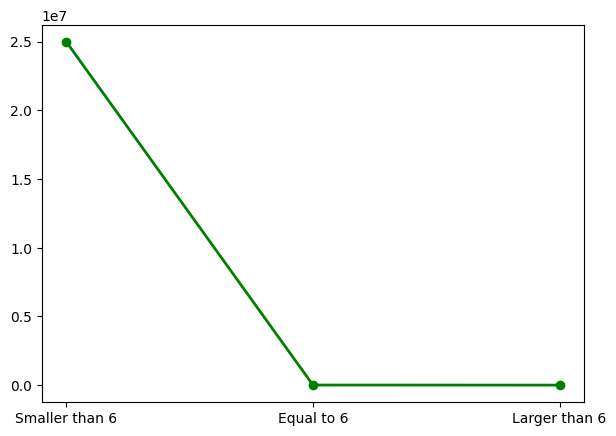

In [36]:
# Visualization
x_dist=['Smaller than 6', 'Equal to 6', 'Larger than 6']
y_count=[degree_less_than_6_count,degree_equal_to_6_count,degree_greater_than_6_count]
fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.plot(x_dist, y_count,'go-', label='line 1', linewidth=2)

<BarContainer object of 3 artists>

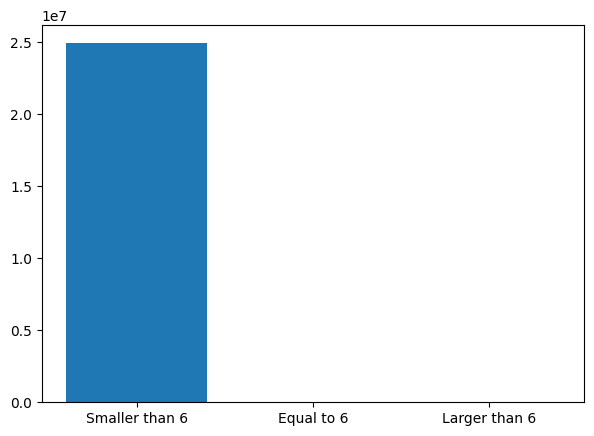

In [37]:
#kwargs = dict(alpha=0.5, bins=100)
#plt.hist(y_count, **kwargs, color='g', label='Ideal')
# bar chart
fig, axes = plt.subplots(figsize=(7,5), dpi=100)
plt.bar(x_dist, height=y_count)

In [38]:
shortest_dist_list.describe()

,dist
count,2.498934e+07
mean,2.658477e+00
std,8.568397e-01
min,1.000000e+00
25%,2.000000e+00
50%,3.000000e+00
75%,3.000000e+00
max,6.400000e+01
